In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors, __version__ as mplver
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy import __version__ as apver
from scipy import stats, __version__ as spver
import warnings
from TESStools import *
from tqdm.notebook import tqdm

In [2]:
test_names = ['HD 269110', 'HD 269902', 'HD 269953']

In [3]:
foo = [0,1,0,0.5,0]
foo[1:]

[1, 0, 0.5, 0]

In [9]:
def harmonic_sin(t, *args):
    f_0 = args[0]
    amps_phis = args[1:]
    n_sins = int(len(amps_phis)/2)
    amps = amps_phis[:n_sins]
    phis = amps_phis[n_sins:]
    return np.sum([parametrized_sin(t,f_0*(i+1),a,p) for i,(a,p) in enumerate(zip(amps,phis))],axis=0)

(0.9986298910581323,
 -0.002691916299243208,
 array([ 1.00001162,  0.99862989,  0.50054122,  0.25190886, -0.00269192,
        -0.00444324, -0.0091315 ]))

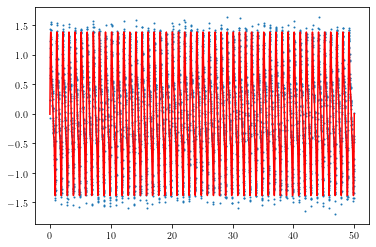

In [20]:
ts = np.linspace(0,50,5000)
f_0 = 1.0
amps = [1.0,0.5,0.25]
phis = [0.0,0.0,0.0]
p0 = np.concatenate([[f_0],amps,phis])
flux = harmonic_sin(ts,*p0)
ls = LombScargle(ts, flux)
f, p = ls.autopower()

f0 = f[f<5][np.argmax(p[f<5])]

obs_flux = flux + 0.1*np.random.randn(len(flux))

A_0 = [np.max(obs_flux)/(2**i) for i in range(3)]
phi_0 = [0 for i in range(3)]
p0 = np.concatenate([[f0], A_0, phi_0])

f_bounds = ([f0-0.1],[f0+0.1])
amp_bounds = ([0 for i in range(3)],[np.inf for i in range(3)])
phi_bounds = ([-np.inf for i in range(3)],[np.inf for i in range(3)])

lbounds = np.concatenate([b[0] for b in [f_bounds,amp_bounds,phi_bounds]])
ubounds = np.concatenate([b[1] for b in [f_bounds,amp_bounds,phi_bounds]])
bounds = (lbounds,ubounds)

popt, pcov = curve_fit(harmonic_sin, ts, obs_flux, bounds=bounds, p0=p0)

plt.scatter(ts, obs_flux,s=1)
plt.plot(ts,harmonic_sin(ts, *popt),c='r')
a = popt[1]
phi = popt[1+3]
a,phi,popt

In [30]:
def prewhiten_harmonic(time, flux, err, verbose = True, red_noise=True, max_freq = np.inf, n_harm=10):
    """
    Runs through a prewhitening procedure to reproduce the variability as sin functions. Now encorporates an optional
    way of fitting for red noise in the periodograms!
    
    Parameters
    ----------
    time : array-like
        times
    flux : array-like
        fluxes
    err : array-like
        corresponding errors.
    verbose : bool
        If set, will print out every 10th stage of prewhitening, as well as some other diagnostics
    red_noise : bool
        If set, will fit for a red noise background model before finding the highest peak
    max_freq : numeric
        Determines the number of frequencies to fit for if given. Default `np.inf`
        
    Returns
    -------
    good_fs : `~numpy.ndarray`
        Nx2 array with first dimension frequencies, and the second errors
    good_amps :`~numpy.ndarray`
        Nx2 array with first dimension amplitudes, and the second errors
    good_amps :`~numpy.ndarray`
        Nx2 array with first dimension amplitudes, and the second errors
    good_snrs :`~numpy.ndarray`
        1D array with signal to noise, calculated directly from the periodogram
    good_peaks :`~numpy.ndarray`
        1D array with the heights of the extracted peaks.
    
    """
    
    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    rayleigh = 1.0 / (np.max(time)-np.min(time))

    #Step 1: subtract off the mean, save original arrays for later
    flux -= np.mean(flux)
    time -= np.mean(time)

    original_flux = flux.copy()
    original_err = err.copy()
    original_time = time.copy()

    found_fs = []
    err_fs = []
    found_amps = []
    err_amps = []
    found_phases = []
    err_phases = []
    found_peaks = []
    found_snrs = []

    #Step 2: Calculate the Lomb Scargle periodogram
    ls = LombScargle(time, flux, normalization='psd')
    frequency, power = ls.autopower(minimum_frequency=1.0/30.0,
                    maximum_frequency=pseudo_NF)
    power /= len(time) #putting into the right units

    #Step 2.5: Normaling by the red noise!
    if red_noise:
        try:
            popt, pcov, resid = fit_red_noise(frequency, power)
            print(popt)
        except RuntimeError:
            popt, pcov, resid = fit_red_noise(frequency[frequency < 50], power[frequency < 50])

        power = resid

    #Step 3: Find frequency of max residual power, and the SNR of that peak
    f_0 = frequency[np.argmax(power)]
    noise_region = (np.abs(frequency - f_0)/rayleigh < 7) & (np.abs(frequency - f_0)/rayleigh > 2)
    found_peaks.append(power.max())
    found_snrs.append(power.max()/np.std(power[noise_region]))

    #Step 4: Fit the sin. Initial guess is that frequency, the max flux point, and no phase
    # Then save the fit params
    A_0 = [np.max(flux)/(2**i) for i in range(n_harm)]
    phi_0 = [0 for i in range(n_harm)]
    p0 = np.concatenate([[f_0], A_0, phi_0])
        
    f_bounds = ([f_0-rayleigh],[f_0+rayleigh])
    amp_bounds = ([0 for i in range(n_harm)],[np.inf for i in range(n_harm)])
    phi_bounds = ([-np.inf for i in range(n_harm)],[np.inf for i in range(n_harm)])

    lbounds = np.concatenate([b[0] for b in [f_bounds,amp_bounds,phi_bounds]])
    ubounds = np.concatenate([b[1] for b in [f_bounds,amp_bounds,phi_bounds]])
    bounds = (lbounds,ubounds)

    popt, pcov = curve_fit(harmonic_sin, time, flux, bounds=bounds, p0=p0)

    found_fs.append(popt[0])
    found_amps.append(popt[1])
    phase = popt[1+n_harm]
    while phase >= np.pi:
        phase -= 2.0*np.pi
    while phase <= -np.pi:
        phase += 2.0*np.pi
    found_phases.append(phase)

    #Calculate the errors
    err_fs.append(np.sqrt(6.0/len(time)) * rayleigh * np.std(flux) / (np.pi * popt[1]))
    err_amps.append(np.sqrt(2.0/len(time)) * np.std(flux))
    err_phases.append(np.sqrt(2.0/len(time)) * np.std(flux) / popt[1])

    #Calculate the BIC up to a constant: -2 log L + m log (N)
    model = harmonic_sin(time, *popt)
    n_pars = len(popt)
    log_like_ish = np.sum(np.power(((original_flux - model) / original_err),2.0))

    bic = log_like_ish + n_pars*np.log(len(time))
    #bic with no fit is:
    old_bic = np.sum(np.power((original_flux/ original_err),2.0))
    bic_dif = bic - old_bic

    #subtract off the fit
    flux -= harmonic_sin(time, *popt)

    #now loop until BIC hits a minimum
    j = 0
    while (bic_dif <= 0) and (len(found_fs) <= max_freq):
        #Reset old_bic
        old_bic = bic
        #Lomb Scargle
        ls = LombScargle(time, flux, normalization='psd')
        frequency, power = ls.autopower(minimum_frequency=1.0/30.0,
                        maximum_frequency=pseudo_NF)

        power /= len(time) #putting into the right units

        #fit
        if red_noise:
            try:
                popt, pcov, resid = fit_red_noise(frequency, power)
                print(popt)
            except RuntimeError:
                popt, pcov, resid = fit_red_noise(frequency[frequency < 50], power[frequency < 50])

            power = resid

        #Highest peak
        f_0 = frequency[np.argmax(power)]
        noise_region = (np.abs(frequency - f_0)/rayleigh < 7) & (np.abs(frequency - f_0)/rayleigh > 2)
        found_peaks.append(power.max())
        found_snrs.append(power.max()/np.std(power[noise_region]))

        #Fit
        A_0 = [np.max(flux)/(2**i) for i in range(n_harm)]
        phi_0 = [0 for i in range(n_harm)]
        p0 = np.concatenate([[f_0], A_0, phi_0])
        
        f_bounds = ([f_0-rayleigh],[f_0+rayleigh])
        amp_bounds = ([0 for i in range(n_harm)],[np.inf for i in range(n_harm)])
        phi_bounds = ([-np.inf for i in range(n_harm)],[np.inf for i in range(n_harm)])

        lbounds = np.concatenate([b[0] for b in [f_bounds,amp_bounds,phi_bounds]])
        ubounds = np.concatenate([b[1] for b in [f_bounds,amp_bounds,phi_bounds]])
        bounds = (lbounds,ubounds)

        popt, pcov = curve_fit(harmonic_sin, time, flux, bounds=bounds, p0=p0)
        
        found_fs.append(popt[0])
        found_amps.append(popt[1])
        phase = popt[1+n_harm]
        while phase >= np.pi:
            phase -= 2.0*np.pi
        while phase <= -np.pi:
            phase += 2.0*np.pi
        found_phases.append(phase)

        #Calculate the errors
        err_fs.append(np.sqrt(6.0/len(time)) * rayleigh * np.std(flux) / (np.pi * popt[1]))
        err_amps.append(np.sqrt(2.0/len(time)) * np.std(flux))      
        err_phases.append(np.sqrt(2.0/len(time)) * np.std(flux) / popt[1])

        #Calculate BIC 
        model += harmonic_sin(time, *popt)
        n_pars += len(popt)
        log_like_ish = np.sum(np.power(((original_flux - model) / original_err),2.0))

        bic = log_like_ish + n_pars*np.log(len(time))
        bic_dif = bic - old_bic

        #subtract off the fit
        flux -= harmonic_sin(time, *popt)
        j+=1
        if (j % 10 == 0) and verbose:
            print(j)
    if verbose:
        print('Found {} frequencies'.format(len(found_fs)-1))
    #if we didn't find any GOOD frequencies, get rid of that ish
    if len(found_fs)-1 == 0:
        return np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    #pop the last from each array, as it made the fit worse, then turn into numpy arrays
    found_fs = np.array(found_fs[:-1])
    found_amps = np.array(found_amps[:-1])
    found_phases = np.array(found_phases[:-1])
    found_snrs = np.array(found_snrs[:-1])
    found_peaks = np.array(found_peaks[:-1])
    err_fs = np.array(err_fs[:-1])
    err_amps = np.array(err_amps[:-1])
    err_phases = np.array(err_phases[:-1])

    #Now loop through frequencies. If any of the less-strong peaks are within 1.5/T,
    #get rid of it.
    good_fs = np.array([[found_fs[0],err_fs[0]]])
    good_amps = np.array([[found_amps[0],err_amps[0]]])
    good_phases = np.array([[found_phases[0],err_phases[0]]])
    good_snrs = np.array([found_snrs[0]])
    good_peaks = np.array([found_peaks[0]])

    for f,ef,a,ea,p,ep,s,pk in zip(found_fs[1:],err_fs[1:],found_amps[1:],err_amps[1:],found_phases[1:],err_phases[1:],found_snrs[1:],found_peaks[1:]):
        if ~np.any(np.abs(good_fs[:,0] - f) <= 1.5*rayleigh):
            good_fs = np.append(good_fs,[[f,ef]],axis=0)
            good_amps = np.append(good_amps,[[a,ea]],axis=0)
            good_phases = np.append(good_phases,[[p,ep]],axis=0)
            good_snrs = np.append(good_snrs,[s],axis=0)
            good_peaks = np.append(good_peaks, [pk],axis=0)
    if verbose:
        print('{} unique frequencies'.format(len(good_fs)))
        
    return good_fs, good_amps, good_phases, good_snrs, good_peaks

In [31]:
this_star = fyps[fyps['CommonName'] == 'HD 269953']
lc, lc_smooth = lc_extract(get_lc_from_id(this_star['TIC ID'].values[0]), smooth=128)
time, flux, err = lc['Time'], lc['Flux'], lc['Err']
good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten_harmonic(time, flux, err, n_harm=3)

[9.31962949e-06 3.30858398e-01 1.54798235e+00 1.30249806e-06]
[1.16439562e-05 4.81844674e-01 1.47201144e+00 1.30265062e-06]
[1.16575161e-05 4.82478537e-01 1.48391151e+00 1.30287015e-06]
[1.23331564e-05 5.32149443e-01 1.46737142e+00 1.30292996e-06]
[1.27577332e-05 5.59015858e-01 1.46836702e+00 1.30308512e-06]
Found 4 frequencies
4 unique frequencies


In [ ]:
#Doing this does change things somewhat
fyps = pd.read_csv('fyps.csv')
for n in test_names:
    this_star = fyps[fyps['CommonName'] == n]
    lc, lc_smooth = lc_extract(get_lc_from_id(this_star['TIC ID'].values[0]), smooth=128)
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    good_fs, good_amps, good_phases, good_snrs, good_peaks = prewhiten_harmonic(time, flux, err, n_harm=3)
    print(n,good_fs[:,0],good_amps[:,0],good_phases[:,0])

In [34]:
# Just for funsies, doing wavelets on Betelgeuse
alpha_ori = pd.read_csv('/Users/carina/Downloads/AlphaOri_AAVSO_ATEL.csv',index_col=0)
alpha_ori

,time,Vmag,Verr
0,1983.164659,0.577,0.024
1,1983.186769,0.604,0.033
2,1984.229878,0.644,0.011
3,1986.992113,0.500,0.003
4,1987.065951,0.478,0.005
...,...,...,...
1577,2020.310934,0.456,0.010
1578,2020.478142,0.660,0.015
1579,2020.530055,0.760,0.015
1580,2020.549180,0.800,0.015


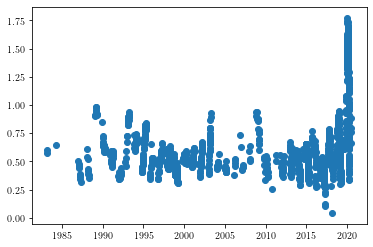

In [35]:
plt.scatter(alpha_ori['time'],alpha_ori['Vmag'])

In [64]:
t = alpha_ori['time'].values
y = alpha_ori['Vmag'].values

#WWZ wavelet fun
#Let's put our functions in a list that we can loop over
func_list = [phi_1,phi_2,phi_3]
f1 = phi_1 #we're also going to need this one explicitly later
#and finally a decay constant for the Gaussian envelope
c = 0.0125
omega_start = np.log2(2.0*np.pi/(10.0)) 
omega_end = np.log2(2.0*np.pi/(0.5))  
omegas = np.logspace(omega_start,omega_end,1000,base=2)
taus = np.linspace(np.min(t),np.max(t),500)
wwz,wwa = MP_WWZ(func_list,f1,y,t,omegas,taus,c=c)

/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'rasteried'
  if sys.path[0] == '':
/Users/carina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10


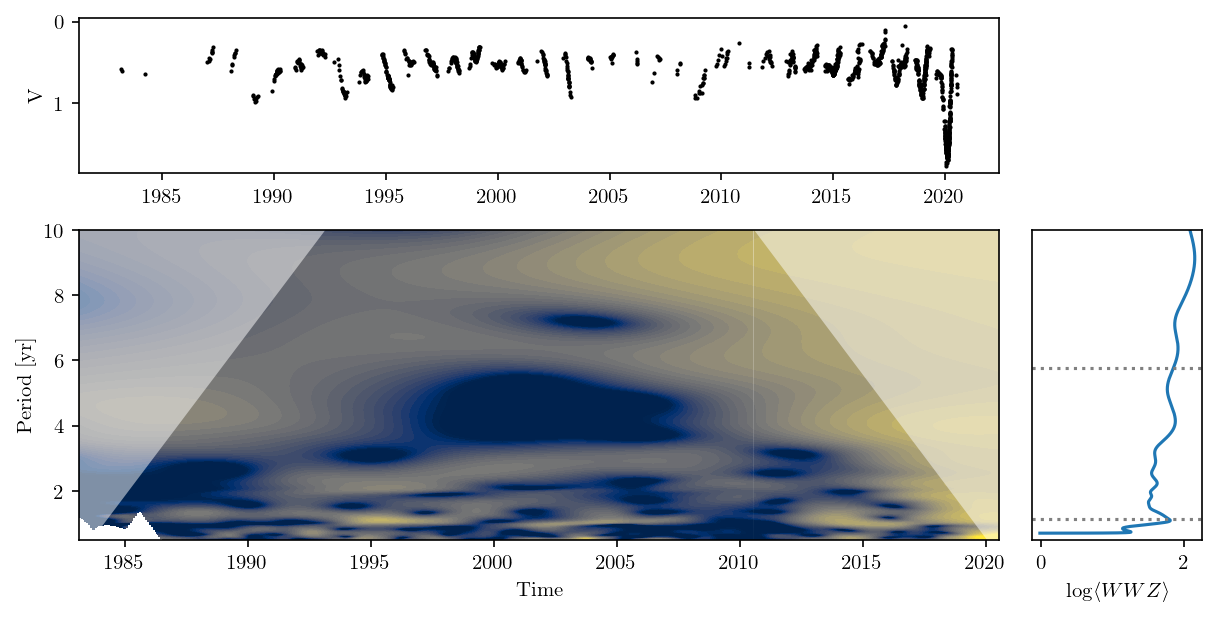

In [118]:
fig = plt.figure(constrained_layout=True,figsize=(8,4),dpi=150)

gs = GridSpec(3, 4, figure=fig)
lcax = fig.add_subplot(gs[0, :3])
wwzax = fig.add_subplot(gs[1:,:3])
zsumax = fig.add_subplot(gs[1:,3])

lcax.scatter(t,y,s=1,c='k',label=r'Data',rasterized=True)
lcax.set(ylabel='V')
lcax.invert_yaxis()

im = wwzax.contourf(taus,1/(omegas/2.0/np.pi),np.log10(wwz),levels=100,cmap='cividis',vmin=0.5,vmax=3,rasteried=True)
fillx_max = np.concatenate([np.max(t)-2*np.pi/omegas,[np.max(t)]])
fillx_min = np.concatenate([2*np.pi/omegas+np.min(t),[np.min(t)]])

filly_max = np.concatenate([[0],1.0/(omegas/2/np.pi)])
filly_min = np.concatenate([1.0/(omegas/2/np.pi),[0]])



wwzax.fill_between(fillx_min,10,filly_min,alpha=0.5,facecolor='white')
wwzax.fill_between(fillx_max,10,filly_max,alpha=0.5,facecolor='white')
wwzax.set(ylabel=r'Period [yr]',xlabel='Time',
          ylim=(1/(np.max(omegas)/2/np.pi),1/(np.min(omegas/2/np.pi))))

zsumax.plot(np.log10(wwz.mean(axis=1)),1/(omegas/2.0/np.pi))
zsumax.axhline(y=420/365,c='grey',ls=':')
zsumax.axhline(y=5.78,c='grey',ls=':')
zsumax.set(xlabel=r'$\log\langle WWZ \rangle$',ylim=(1/(np.max(omegas)/2/np.pi),1/(np.min(omegas/2/np.pi))),yticks=[])

#cb = plt.colorbar(im,label=r'$\log WWZ $',extend=True)
#cb.set_clim=(0.5,3)
plt.savefig('/Users/carina/Desktop/betelgeuse.png',bbox_inches='tight')